In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# V.1 Exploring the green reds

## a) Write a function that will plot a scatterplot matrix of your red wine data.

In [30]:
red = pd.read_csv("winequality-red.csv", sep=';')
white = pd.read_csv("winequality-white.csv", sep=';')

In [31]:
def threshold(quality, good, bad):
    new = quality.copy()
    for idx, item in enumerate(new):
        if (item >= good):
            new[idx] = 'g'
        elif (item <= bad):
            new[idx] = 'r'
        else:
            #Make all in-between qualities transparent
            new[idx] = '#ffffff00'
    return (new)

In [32]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    color = threshold(wine_data['quality'], good_threshold, bad_threshold)
    name = wine_data.columns
    size = len(wine_data.columns)
    fig, ax = plt.subplots(size, size, figsize = (20, 20))
    i = 0
    for row in ax:
        x = wine_data.iloc[:, i]
        i += 1
        j = 0
        for col in row:
            y = wine_data.iloc[:, j]
            j += 1
            col.axis('off')
            if (i == j):
                col.text(0.5, 0.5, name[i - 1], horizontalalignment='center', verticalalignment='center', transform=col.transAxes);
            else:
                col.scatter(x, y, c = color, marker = ".")
    if (save_plot):
        plt.savefig('plot.png')
    else:
        plt.show()

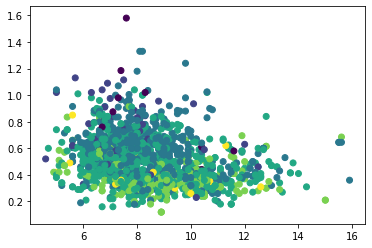

In [33]:
x = red['fixed acidity']
y = red['volatile acidity']
plt.scatter(x, y, c = red['quality'])
plt.show()

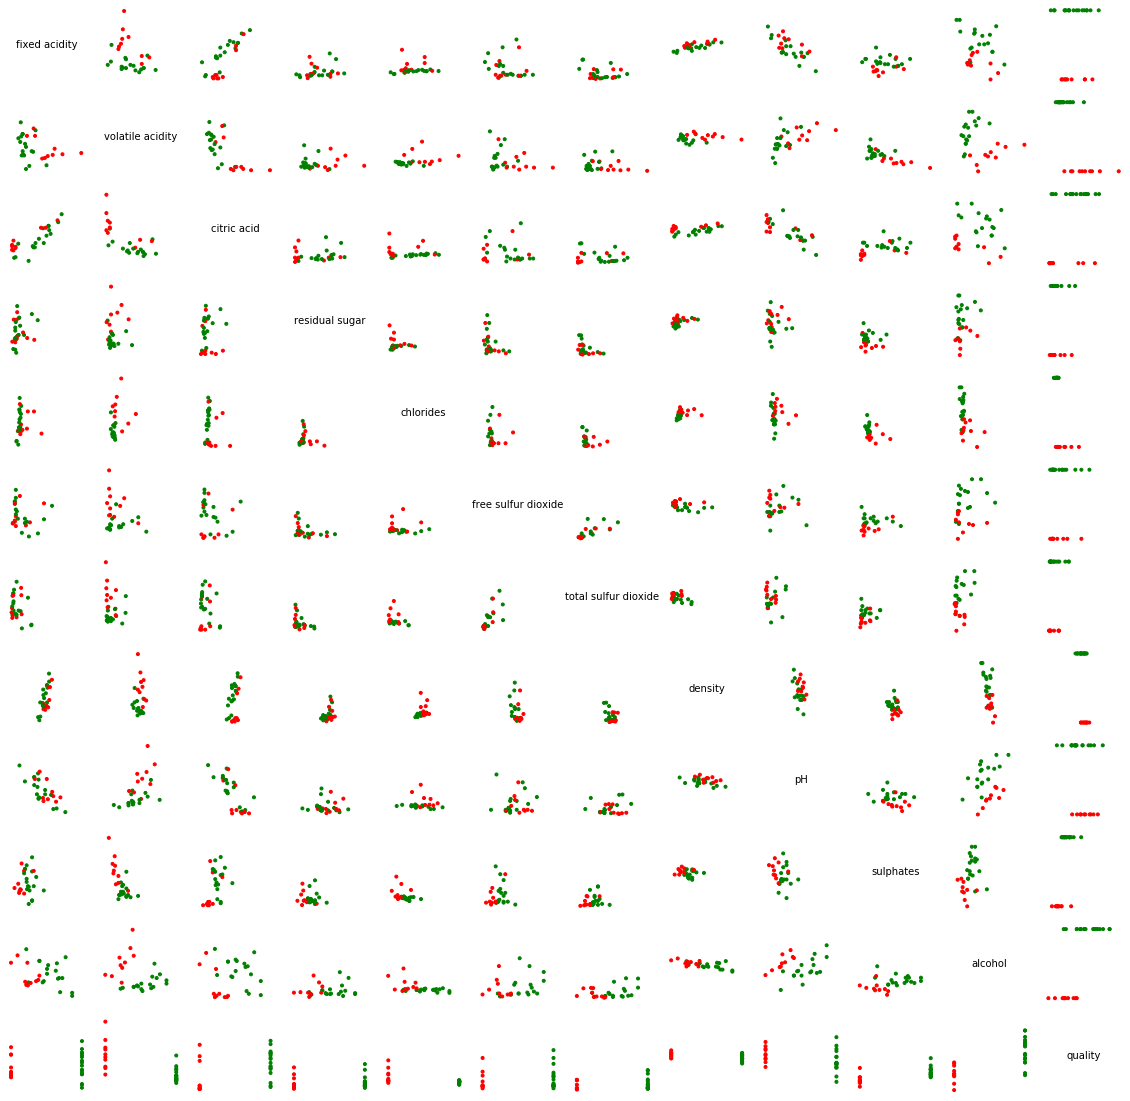

In [34]:
plot_scatter_matrix(red, 8, 3)

## b) Which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

Alcohol, volatile acid and pH. <br>
Because these are the ones that feel the most separated between good and bad.

# V.2 Learning to perceptron

## a) Implement a perceptron that:
• Has randomly initialized weights and bias<br>
• Uses the Rosenblatt perceptron learning rule (with changeable learning rate)<br>
• Utilizes the heaviside step activation function (discrete version)